<a href="https://colab.research.google.com/github/Kushagratandon12/Image_Caption_Generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/sample_data/
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import random
import seaborn as sns
import cv2
import os
from google.colab import drive
import tqdm
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 4/1AY0e-g7UIDP8GN0MEzfKxYwDlF2OQSuY1VnGsDFRBPSwR6hIJGfdyJsLN78
drive.mount('Mydrive')

Mounted at Mydrive


In [ ]:
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip  '/content/flickr-image-dataset.zip' -d '/content/Mydrive/MyDrive/Image_Caption_Dataset'
# !rm -rf /content/flickr-image-dataset.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(375, 500, 3)
(331, 500, 3)
(500, 333, 3)
(500, 281, 3)
(375, 500, 3)
(500, 400, 3)
(500, 333, 3)
(375, 500, 3)


19

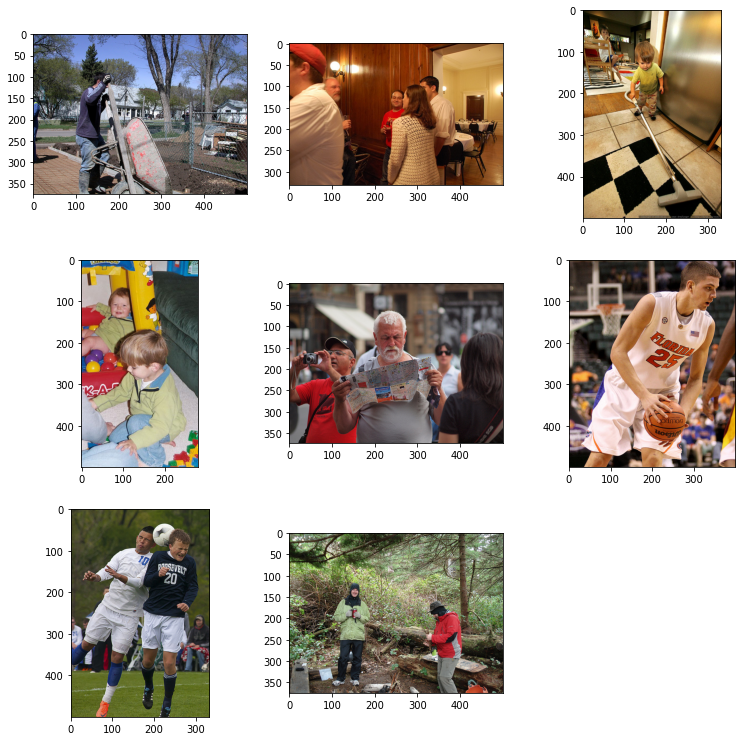

In [5]:
# Images Present Inside The Dataset 
images_data = glob.glob('/content/Mydrive/MyDrive/Image_Caption_Dataset/flickr30k_images/flickr30k_images/*.jpg')
base_path = '/content/Mydrive/MyDrive/Image_Caption_Dataset/flickr30k_images/flickr30k_images/'
print(images_data)
random.shuffle(images_data)
plt.figure(figsize=(13,13))
for i in range(1,9):
  plt.subplot(3,3,i)
  img = plt.imread(images_data[i-1])
  print(img.shape)
  plt.imshow(img)

gc.collect()

In [2]:
#Understanding The Text Data 
text_data = pd.read_csv('/content/Mydrive/MyDrive/Image_Caption_Dataset/flickr30k_images/flickr30k_images/results.csv', sep='|')
text_data.columns = ['image', 'caption_number', 'caption']
text_data['caption'] = text_data['caption'].str.lstrip()
text_data['caption_number'] = text_data['caption_number'].str.lstrip()

ids = [id_ for id_ in range(len(text_data) // 5) for i in range(5)]
text_data['ids'] = ids
# text_data['image'] = text_data.apply(lambda x : '/content/flickr30k_images/flickr30k_images/' + text_data['image'])
text_data.head(15)

,image,caption_number,caption,ids
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0
5,10002456.jpg,0,Several men in hard hats are operating a giant...,1
6,10002456.jpg,1,Workers look down from up above on a piece of ...,1
7,10002456.jpg,2,Two men working on a machine wearing hard hats .,1
8,10002456.jpg,3,Four men on top of a tall structure .,1
9,10002456.jpg,4,Three men on a large rig .,1


In [3]:
text_data.loc[19999, 'caption_number'] = "4"
text_data.loc[19999, 'caption'] = "A dog runs across the grass ."

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


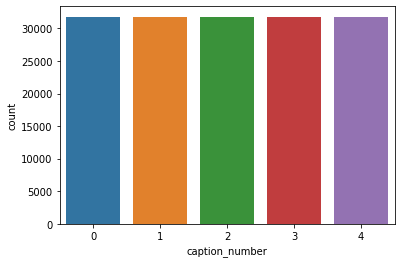

In [4]:
sns.countplot(text_data['caption_number'])

In [6]:
image_name = {
    'image_name':text_data[text_data['caption_number'] == text_data['caption_number'][0]]['image'].values,
}
comments = {
    'comment_0':text_data[text_data['caption_number'] == text_data['caption_number'][0]]['caption'].values,
    'comment_1':text_data[text_data['caption_number'] == text_data['caption_number'][1]]['caption'].values,
    'comment_2':text_data[text_data['caption_number'] == text_data['caption_number'][2]]['caption'].values,
    'comment_3':text_data[text_data['caption_number'] == text_data['caption_number'][3]]['caption'].values,
    'comment_4':text_data[text_data['caption_number'] == text_data['caption_number'][4]]['caption'].values,
}

image_name_df = pd.DataFrame.from_dict(image_name)
comments_df = pd.DataFrame.from_dict(comments)

df = pd.concat([image_name_df,comments_df], axis=1)
df['image_name'] = df.apply(lambda x : base_path + df['image_name'])
gc.collect()
df.head()

,image_name,comment_0,comment_1,comment_2,comment_3,comment_4
0,/content/Mydrive/MyDrive/Image_Caption_Dataset...,Two young guys with shaggy hair look at their ...,"Two young , White males are outside near many ...",Two men in green shirts are standing in a yard .,A man in a blue shirt standing in a garden .,Two friends enjoy time spent together .
1,/content/Mydrive/MyDrive/Image_Caption_Dataset...,Several men in hard hats are operating a giant...,Workers look down from up above on a piece of ...,Two men working on a machine wearing hard hats .,Four men on top of a tall structure .,Three men on a large rig .
2,/content/Mydrive/MyDrive/Image_Caption_Dataset...,A child in a pink dress is climbing up a set o...,A little girl in a pink dress going into a woo...,A little girl climbing the stairs to her playh...,A little girl climbing into a wooden playhouse,A girl going into a wooden building .
3,/content/Mydrive/MyDrive/Image_Caption_Dataset...,Someone in a blue shirt and hat is standing on...,A man in a blue shirt is standing on a ladder ...,A man on a ladder cleans the window of a tall ...,man in blue shirt and jeans on ladder cleaning...,a man on a ladder cleans a window
4,/content/Mydrive/MyDrive/Image_Caption_Dataset...,"Two men , one in a gray shirt , one in a black...",Two guy cooking and joking around with the cam...,Two men in a kitchen cooking food on a stove .,Two men are at the stove preparing food .,Two men are cooking a meal .


4

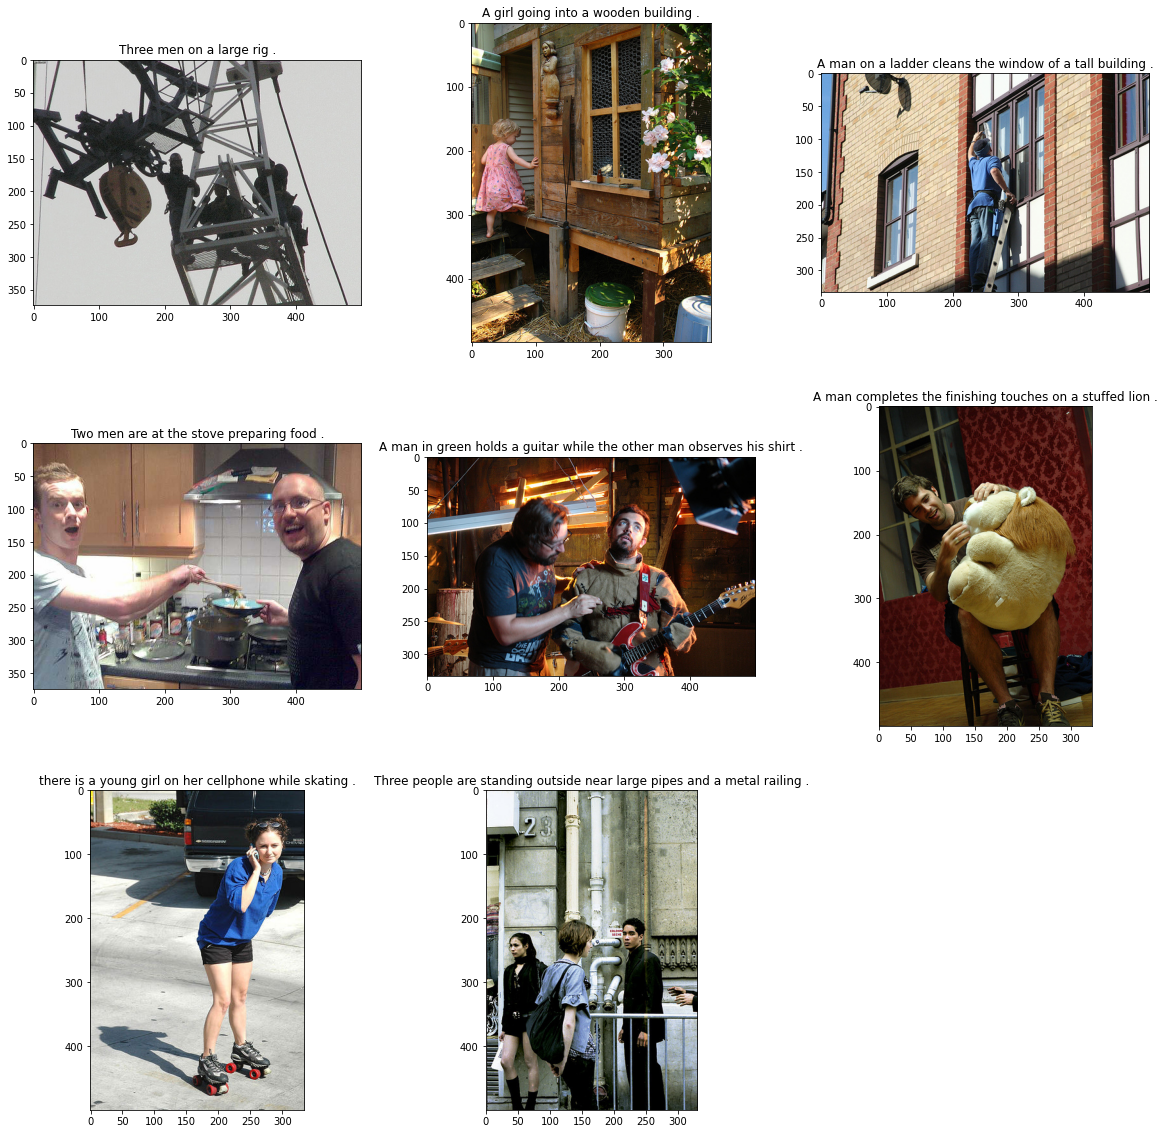

In [7]:
plt.figure(figsize=(20,20))
for i in range(1,9):
  plt.subplot(3,3,i)
  img = plt.imread(df['image_name'][i])
  plt.title(df['comment_'+str(np.random.randint(1,5))][i])
  plt.imshow(img)
gc.collect()

In [8]:
train, test= train_test_split(df, test_size=0.2, random_state=42)
## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
## Obtain Train and Validation Split 
train, val = train_test_split(train, test_size=0.25, random_state=42)
## Reset Indexes 
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

(19069, 6)
(6357, 6)
(6357, 6)


# Extract Features -> CNN

In [10]:
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray 
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [ ]:
feature_CNN = {} #Features For CNN Network

def extracting_image_features(images_data,img_shape):
  model = tf.keras.applications.InceptionV3(include_top=False,input_shape=(320,320,3),weights='imagenet')
  for img in images_data:
    image = decode_img(img,shape=img_shape)
    extracted_feature = model.predict(image)
    feature_CNN[img] = extracted_feature
  return feature_CNN

feature_CNN = extracting_image_features(images_data,(320,320))

In [ ]:
dump(features_CNN,open("features_cnn.p",'wb'))